# Prepare

## import library

In [10]:
!pip install pmdarima

In [1]:
# 라이브러리 임포트
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import autograd
from torch.utils import data
from torch.optim import Adam

import matplotlib.pyplot as plt
from pmdarima.arima import ndiffs
import pmdarima as pm

In [2]:
# 난수 생성기가 항상 일정한 값을 출력하게 하기 위해 seed 고정
random_seed = 2021
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

## Connect Google dirve

In [3]:
from google.colab import drive


drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/팀 프로젝트/Traffic_prediction/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DATASET_PATH = 'data'

## Load data

In [5]:
train_df = pd.read_csv(os.path.join(DATASET_PATH, 'fill_NA(mean)2.csv'))
train_df

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200101,0,83247,19128,2611,5161,1588,892,32263,1636,7938,1894,14957,3527,11174,2930,8640,14175,2035,5231,18492,48520,15393,16628,8804,2790,38657,1311,3482,11299,7072,1176,3810,748,3920,2133,3799
1,20200101,1,89309,19027,3337,5502,1650,1043,35609,1644,9896,1967,14682,3420,13884,3062,8349,15654,2417,5483,15283,57904,15834,19785,8483,3381,45759,1162,3849,13180,8771,1283,3763,782,3483,2057,4010
2,20200101,2,66611,14710,2970,4631,1044,921,26821,1104,9343,1838,11120,3587,17141,3255,7025,12520,1859,5058,14327,53876,13866,24501,8167,2670,27425,768,2299,7986,5426,1536,3229,491,2634,1526,3388
3,20200101,3,53290,13753,2270,4242,1021,790,21322,909,10009,1630,9836,3842,20715,2661,7226,9821,1724,4863,12787,51615,13528,28695,9459,2325,18893,632,1716,5703,3156,1104,2882,431,2488,1268,3686
4,20200101,4,52095,17615,2406,3689,1840,922,22711,1354,15497,1264,10668,4559,28308,2894,8201,9038,960,5166,11479,47424,18156,26977,10944,3583,18135,875,2421,5816,2933,1206,2433,499,2952,1927,5608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,20200517,19,311727,101285,10085,30637,10060,8749,148935,6801,26101,9370,74169,17764,34715,19806,42734,63382,14130,34866,71475,96849,79150,25109,14680,10465,128344,6726,15431,25597,14292,9300,22238,3786,16936,10729,20194
3308,20200517,20,305354,91426,8607,26021,8095,7198,136503,6147,20759,8432,68923,14593,30279,17634,37661,57815,13055,31943,65378,92116,72379,23165,11879,9135,131682,5501,15378,24661,14747,8239,20604,3203,15018,9767,17962
3309,20200517,21,306008,75113,6325,19933,5711,4494,129412,5134,14496,6739,54455,11997,27047,15943,29029,54627,12292,27424,60696,83628,57866,16629,8573,6488,127826,4216,12558,22781,14081,6392,17937,2447,12403,7825,14031
3310,20200517,22,237447,49498,4209,12145,3891,2718,96698,3526,9363,4543,35618,7996,19478,10010,18663,39694,8818,17770,45983,57321,35250,10761,5331,4109,94288,2578,8870,16640,11066,4427,11955,1495,7507,5387,8889


In [7]:
test_df = pd.read_csv(os.path.join(DATASET_PATH, 'test.csv'))
test_df

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200518,0,82065,15172,1500,3294,1086,962,28931,1103,3014,1619,12596,3060,7383,2958,5829,11297,2890,5694,19553,18919,9907,2912,1884,1112,28189,618,2790,5147,4331,1329,3665,404,2242,1619,2314
1,20200518,1,51248,9840,813,2356,696,546,17888,720,1839,1502,7741,2132,4790,1743,4296,6781,1752,3651,12454,11849,6292,1750,1118,703,16683,430,1864,3269,2561,921,2081,272,1390,1003,1766
2,20200518,2,39026,7894,760,2413,408,549,13357,498,1360,1233,6475,2098,3965,1345,3957,4762,1250,3199,9640,9392,4961,1104,1004,485,11934,322,1313,2765,1931,920,1764,228,1136,922,1309
3,20200518,3,40993,10137,780,2701,420,741,15544,532,1671,1800,7720,2133,4083,1501,3992,6202,1505,4459,10802,11664,6015,1132,1061,851,13458,326,1766,3320,2060,892,2447,337,1495,975,1912
4,20200518,4,77863,19603,1276,5019,968,1160,32101,968,2574,2384,12018,3502,6430,2882,5957,11987,3176,9054,16490,23479,10676,1945,1520,1420,31698,669,2914,6986,3911,1368,4380,513,2940,1758,3629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,20200531,19,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
332,20200531,20,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
333,20200531,21,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
334,20200531,22,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [63]:
pred = pd.read_csv(os.path.join(DATASET_PATH, 'sample_submission.csv'))
pred

,timestamp,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200525_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20200525_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20200525_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20200525_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20200525_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,20200531_19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164,20200531_20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
165,20200531_21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166,20200531_22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Make traffic per date/time data

In [12]:
per_date = train_df.groupby(['날짜']).sum().reset_index()
per_date = per_date.drop(columns='시간')
per_date['날짜'] = pd.to_datetime(per_date['날짜'], format="%Y%m%d")
per_date

,날짜,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,2020-01-01,5006706,1607813,216087,481235,182757,115300,2316399,130114,516721,164605,1077210,328368,875554,332798,821729,965420,151713,507011,1163074,2126998,1420891,669691,494287,244083,2131684,108535,234214,553083,270659,139350,334162,66950,267826,162546,366594
1,2020-01-02,5390294,1638834,165724,403004,152083,104069,2227595,113220,263870,149250,1045965,295535,449500,261442,659807,1015629,166391,527598,1211891,1828466,1265277,326095,291986,163767,2572271,123915,263751,695526,348094,103901,339314,69792,311813,172577,346672
2,2020-01-03,6079899,1777802,190067,473078,166017,122349,2499240,121370,294028,172253,1196158,332920,539675,294877,725243,1141802,185427,595687,1405572,2019952,1451357,359850,315100,182962,2673751,144580,272906,677219,371390,120859,392128,72021,349457,190175,377754
3,2020-01-04,5725885,1743939,193869,510606,179314,118473,2597776,124013,379395,168330,1243317,333022,556810,320065,796573,1126244,185047,550144,1272515,2089279,1256110,525586,391430,202141,2550240,138880,266273,569333,330755,117240,388329,74954,320370,178774,372421
4,2020-01-05,5180150,1545929,172876,483723,150186,107015,2355430,113277,366770,151876,1082398,289692,565761,287022,782302,998284,190490,473791,1195483,1822272,1085878,464135,336850,185116,2163717,114246,239678,507174,272263,126264,336935,62068,270039,148609,312512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,2020-05-13,5427421,1624291,167447,422851,162437,112811,2257296,101235,254603,148142,1131472,276708,469783,307559,550532,1102165,222063,577543,1175811,1696322,1133109,253335,241679,147368,2960542,123969,282051,671596,292582,103790,362432,65343,329423,206451,344123
134,2020-05-14,5595033,1661805,172299,441314,163331,116983,2340831,107113,264905,151759,1154121,280189,493558,295342,600963,1094543,233360,597737,1206636,1728193,1174470,270302,245836,158998,2986004,131894,289938,666188,377794,107637,378173,57639,322832,220254,356759
135,2020-05-15,5729067,1663937,171382,429070,149141,121189,2437721,109341,265837,162226,1190904,288189,535793,319649,632159,1088795,224369,628789,1283137,1784735,1301060,336896,270723,150564,2656727,130855,288363,639007,352267,114330,399211,44549,319609,212776,346983
136,2020-05-16,5719070,1834329,206927,532645,196345,146078,2805512,120483,373552,161697,1355929,314055,549172,364988,702312,1168268,246744,648842,1140690,1942206,1395103,501204,328912,185931,2726927,137992,290508,607064,339408,159402,424661,72791,319778,218720,378043


In [23]:
per_time = train_df.groupby(['시간']).sum().reset_index()
per_time = per_time.drop(columns='날짜')
# 우리가 원하는건 각 시간대별 비율이므로 비율을 구해 저장해줌
per_time[per_time.columns[1:]] = per_time[per_time.columns[1:]] / per_time[per_time.columns[1:]].sum(axis=0)
per_time

,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,0,0.014413,0.009145,0.006949,0.008179,0.006667,0.008373,0.012318,0.009357,0.008397,0.010716,0.011274,0.011046,0.012232,0.008366,0.009937,0.010532,0.010276,0.008899,0.017914,0.011098,0.008183,0.007670,0.007084,0.006684,0.011878,0.006389,0.010627,0.011280,0.015369,0.011003,0.010546,0.008264,0.007478,0.008058,0.006795
1,1,0.010240,0.006230,0.004857,0.006027,0.004358,0.006199,0.008610,0.006412,0.006414,0.008490,0.007959,0.008651,0.009304,0.005967,0.007473,0.007467,0.007458,0.006779,0.013304,0.008052,0.005655,0.005221,0.004954,0.004629,0.007721,0.004105,0.007260,0.007315,0.010266,0.008977,0.007839,0.005839,0.005159,0.005643,0.004910
2,2,0.008127,0.005144,0.004199,0.005135,0.003111,0.005177,0.006670,0.004879,0.005503,0.008125,0.006387,0.007996,0.008168,0.005169,0.006329,0.006073,0.005898,0.006204,0.010615,0.006688,0.004690,0.004189,0.003893,0.003843,0.005646,0.003040,0.005681,0.005681,0.007525,0.007512,0.006629,0.004812,0.004250,0.004724,0.004132
3,3,0.007952,0.005950,0.004392,0.005466,0.003010,0.005263,0.006619,0.004963,0.005707,0.010379,0.006418,0.008652,0.008593,0.005328,0.006556,0.006118,0.005929,0.007324,0.010535,0.006915,0.004823,0.004104,0.003835,0.004971,0.005328,0.002949,0.005895,0.005849,0.006782,0.007449,0.006811,0.004727,0.004847,0.004780,0.004871
4,4,0.010890,0.009754,0.006439,0.008448,0.004417,0.006945,0.009935,0.007708,0.007305,0.012544,0.008115,0.011646,0.011459,0.007293,0.008613,0.008653,0.009494,0.011316,0.013766,0.010672,0.006955,0.005174,0.005098,0.008388,0.008526,0.004437,0.009051,0.009687,0.009746,0.009454,0.009142,0.007347,0.007848,0.007612,0.008024
5,5,0.020505,0.018008,0.012742,0.014127,0.011259,0.012084,0.021156,0.015551,0.012559,0.015806,0.013623,0.016910,0.016926,0.013072,0.013365,0.018426,0.023039,0.021710,0.019895,0.023115,0.013270,0.008573,0.009118,0.015582,0.025588,0.010566,0.020650,0.025756,0.026545,0.013939,0.014908,0.013686,0.015952,0.016826,0.017116
6,6,0.035874,0.033126,0.026330,0.024083,0.029968,0.023243,0.034148,0.029954,0.023122,0.022671,0.025701,0.025058,0.023645,0.024453,0.021908,0.032867,0.038151,0.035145,0.027163,0.036923,0.026698,0.015050,0.018693,0.032371,0.044552,0.029615,0.043018,0.046788,0.046611,0.021145,0.025515,0.028828,0.038492,0.035652,0.035251
7,7,0.048090,0.050277,0.042230,0.038032,0.053421,0.040537,0.043575,0.046687,0.036906,0.034521,0.042960,0.033063,0.030506,0.039935,0.034348,0.047798,0.046587,0.049640,0.034124,0.048194,0.043739,0.024681,0.031710,0.048330,0.055831,0.061254,0.057589,0.059556,0.058329,0.029513,0.044705,0.059596,0.067399,0.057740,0.056616
8,8,0.051509,0.052768,0.051131,0.049214,0.060660,0.050628,0.048538,0.054265,0.043586,0.042592,0.050586,0.040875,0.038714,0.047119,0.044105,0.052872,0.052076,0.053304,0.039154,0.052763,0.051179,0.034906,0.045886,0.047277,0.057345,0.059588,0.056718,0.057968,0.057743,0.038233,0.053729,0.072725,0.065701,0.060281,0.057383
9,9,0.053463,0.056220,0.057002,0.056325,0.057878,0.054783,0.054892,0.057111,0.052681,0.050870,0.055737,0.049599,0.046852,0.054579,0.051110,0.057852,0.058101,0.059747,0.047290,0.055869,0.055907,0.047308,0.053008,0.056855,0.056855,0.056879,0.056395,0.056507,0.054400,0.050238,0.054916,0.055526,0.058514,0.058539,0.057981


In [24]:
# 제대로 비율이 나눠졌는지 확인(1.0이 아니면 오류)
per_time.sum(axis=0)

시간      276.0
10        1.0
100       1.0
101       1.0
120       1.0
121       1.0
140       1.0
150       1.0
160       1.0
200       1.0
201       1.0
251       1.0
270       1.0
300       1.0
301       1.0
351       1.0
352       1.0
370       1.0
400       1.0
450       1.0
500       1.0
550       1.0
600       1.0
650       1.0
652       1.0
1000      1.0
1020      1.0
1040      1.0
1100      1.0
1200      1.0
1510      1.0
2510      1.0
3000      1.0
4510      1.0
5510      1.0
6000      1.0
dtype: float64

## Remove Sulnal

In [25]:
after_sul = per_date[per_date['날짜']>'2020-01-31']

# Define ARIMA model

## Define d(차수) of ARIMA

차수를 어떻게 정할지 모르겠으면 이런방식으로 정하면 된다.(d = n_diff)

In [30]:
# 각 도로 목록 저장
highways = list(after_sul.columns[1:])

In [31]:
kpss_diffs = ndiffs(after_sul[highways[0]], alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(after_sul[highways[0]], alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

In [32]:
n_diffs

1

## Define p(AR모델의 차수), q(MA모델의 차수) of ARIMA

원래는 아래의 그래프를 보고 정해야하는데......

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


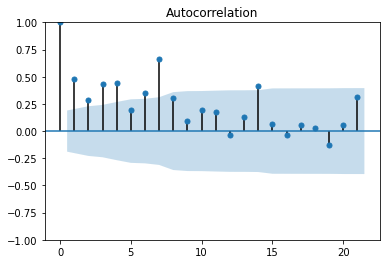

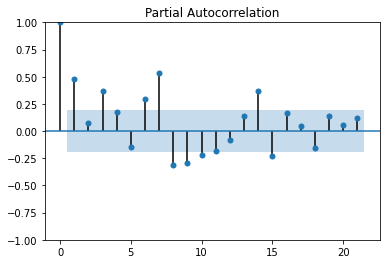

In [34]:
plot_acf(after_sul[highways[0]])
plot_pacf(after_sul[highways[0]])
plt.show()

봐도 모르겠으니 라이브러리(auto_arima)를 이용한다.

In [35]:
# start_p, max_p / start_q, max_q 범위를 탐색 / m은 계절 주기(일별 데이터이므로 7(일주일)을 넣었음)
# stepwise 탐색할 알고리즘 선택, trace 로그 확인
model = pm.auto_arima(y = after_sul[highways[0]],
                      d = 1,
                      start_p = 0,
                      max_p = 3,
                      start_q = 0,
                      max_q = 3,
                      m = 7,
                      stepwise=True,
                      trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=3100.663, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3120.777, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3096.456, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3096.121, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3118.782, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=3106.706, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=3089.673, Time=0.16 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=3092.522, Time=0.07 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=3091.670, Time=0.32 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=3091.671, Time=0.26 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=3093.036, Time=0.13 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=3090.934, Time=0.16 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=3093.310, Time=0.45 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=3091.158, Time=0.23 sec
 ARIMA(0,1,2)(1,0,1)[7] intercept

# Check model

해당 모델이 나름 쓸만한지 아닌지 잔차를 통해 분석할 수 있다.<br>
물어보면 대충 알려줄 순 있는데 나도 자세히는 모름...<br>
확실하게 아는건 잔차의 histogram이 정규분포와 비슷한 형태를 띄면 올바른 모델이라는 것

In [36]:
model.fit(after_sul[highways[0]])

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [37]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  107
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1539.795
Date:                           Wed, 16 Feb 2022   AIC                           3087.590
Time:                                   08:27:09   BIC                           3098.244
Sample:                                        0   HQIC                          3091.908
                                           - 107                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2664      0.062     -4.264      0.000      -0.389      -0.144
ar.S.L7        0.7726      0.106      7.297      0.000       0.565       0.980
ma.S.L7       -0.6071      0.127     -4.790      0.000      -0.855      -0.359
sigma2      2.684e+11   1.16e-13   2.32e+24      0.000    2.68e+11    2.68e+11
===================================================================================
Ljung-Box (L1) (Q):                   1.55   Jarque-Bera (JB):                 4.00
Prob(Q):                              0.21   Prob(JB):                         0.14
Heteroskedasticity (H):               0.54   Skew:                            -0.44
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.44e+40. Standard errors may be unstable.
"""

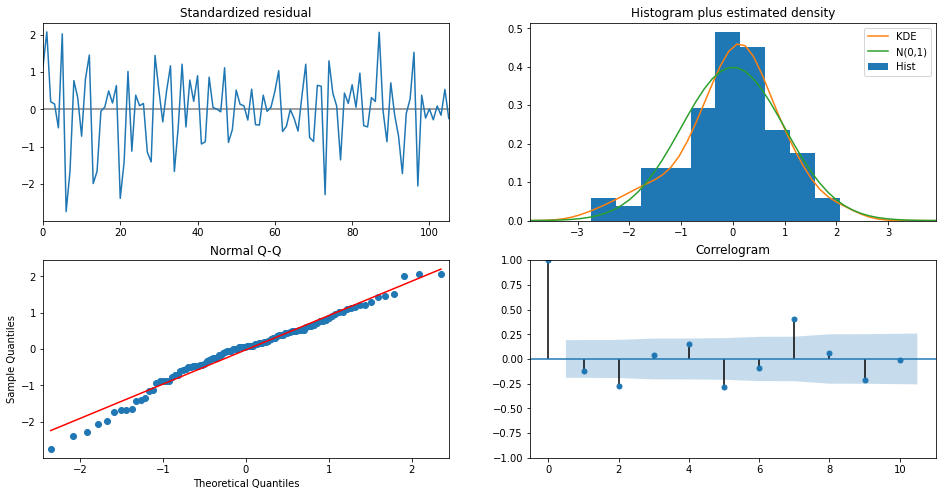

In [38]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

# Make Prediction

ARIMA는 1차원 데이터 예측이라 그런지 각 도로별 데이터를 넣어야 작동했다.<br>
각 도로별로 model을 fit한 뒤 예측하여 앞에서 구한 시간대별 분포로 예측값을 채워넣겠다.

In [65]:
pred_list = [[] for _ in range(len(highways))]

for i in range(len(highways)):
    model.fit(after_sul[highways[i]])
    y_predict = model.predict(n_periods=7)
    for user in y_predict:
        pred_list[i].extend(list(per_time['10'] * user))
    pred[highways[i]] = pred_list[i]

In [68]:
pred.to_csv('predict(ARIMA).csv', index=False)

In [71]:
ma7 = per_date['10'].rolling(window=7).mean()